# ✈️ European Flights Traffic Analysis

## Introduction
Air traffic data provides valuable insights into transportation demand, seasonal trends,
and operational behavior across regions. This project focuses on analyzing European flight
traffic using historical airport-level data.

The study applies exploratory data analysis and machine learning techniques to understand
traffic variability and to predict both flight volume and high-traffic periods. Due to the
large size of the dataset, memory-efficient data processing techniques are used throughout
the analysis.

## Key Goals
- Analyze long-term and seasonal flight trends
- Compare traffic levels across countries and airports
- Predict daily flight counts using regression models
- Classify high-traffic days using supervised learning


# 1. Imports & Environment Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier,
    GradientBoostingRegressor
)

plt.rcParams.update({'figure.dpi': 100})
pd.options.display.max_columns = 50

# Why: loads essential libraries for cleaning, plotting, and modeling.
# Matplotlib is used for plotting. sklearn used for basic models and metrics.

# 2. Dataset Path & Initial Validation

In [5]:
from google.colab import files
files.upload()
df = pd.read_csv("European Flights.csv")
df.head()


Saving European Flights.csv to European Flights.csv


,YEAR,MONTH_NUM,MONTH_MON,FLT_DATE,APT_ICAO,APT_NAME,STATE_NAME,FLT_DEP_1,FLT_ARR_1,FLT_TOT_1,FLT_DEP_IFR_2,FLT_ARR_IFR_2,FLT_TOT_IFR_2,Pivot Label
0,2016,1,JAN,2016-01-01T00:00:00Z,EBAW,Antwerp,Belgium,4,3,7,NaN,NaN,NaN,Antwerp (EBAW)
1,2016,1,JAN,2016-01-01T00:00:00Z,EBBR,Brussels,Belgium,174,171,345,174.0,161.0,335.0,Brussels (EBBR)
2,2016,1,JAN,2016-01-01T00:00:00Z,EBCI,Charleroi,Belgium,45,47,92,45.0,45.0,90.0,Charleroi (EBCI)
3,2016,1,JAN,2016-01-01T00:00:00Z,EBLG,Liège,Belgium,6,7,13,NaN,NaN,NaN,Liège (EBLG)
4,2016,1,JAN,2016-01-01T00:00:00Z,EBOS,Ostend-Bruges,Belgium,7,7,14,NaN,NaN,NaN,Ostend-Bruges (EBOS)


In [7]:
# ---------- 2. DATASET UPLOAD & VALIDATION ----------
from google.colab import files
files.upload()   # Upload "European Flights.csv"

file_path = "European Flights.csv"

print("File exists:", os.path.exists(file_path))
print("File path:", file_path)

# Quick preview
df_preview = pd.read_csv(file_path, nrows=5)
df_preview


Saving European Flights.csv to European Flights (1).csv
File exists: True
File path: European Flights.csv


,YEAR,MONTH_NUM,MONTH_MON,FLT_DATE,APT_ICAO,APT_NAME,STATE_NAME,FLT_DEP_1,FLT_ARR_1,FLT_TOT_1,FLT_DEP_IFR_2,FLT_ARR_IFR_2,FLT_TOT_IFR_2,Pivot Label
0,2016,1,JAN,2016-01-01T00:00:00Z,EBAW,Antwerp,Belgium,4,3,7,NaN,NaN,NaN,Antwerp (EBAW)
1,2016,1,JAN,2016-01-01T00:00:00Z,EBBR,Brussels,Belgium,174,171,345,174.0,161.0,335.0,Brussels (EBBR)
2,2016,1,JAN,2016-01-01T00:00:00Z,EBCI,Charleroi,Belgium,45,47,92,45.0,45.0,90.0,Charleroi (EBCI)
3,2016,1,JAN,2016-01-01T00:00:00Z,EBLG,Liège,Belgium,6,7,13,NaN,NaN,NaN,Liège (EBLG)
4,2016,1,JAN,2016-01-01T00:00:00Z,EBOS,Ostend-Bruges,Belgium,7,7,14,NaN,NaN,NaN,Ostend-Bruges (EBOS)


# 3. Memory-Safe Read & Cleaning (Chunk Processing)

In [8]:
# ---------- 3. MEMORY-SAFE READ & CLEAN ----------
chunksize = 100000
cleaned_csv = "European_Flights_cleaned.csv"

if os.path.exists(cleaned_csv):
    os.remove(cleaned_csv)

usecols_guess = [
    'FLT_DATE','APT_ICAO','APT_NAME','STATE_NAME',
    'FLT_DEP_1','FLT_ARR_1','FLT_TOT_1',
    'FLT_DEP_IFR_2','FLT_ARR_IFR_2','FLT_TOT_IFR_2'
]

existing_cols = pd.read_csv(file_path, nrows=1).columns.str.strip().tolist()
usecols = [c for c in usecols_guess if c in existing_cols]
print("Columns used:", usecols)

country_totals = defaultdict(float)
airport_totals = defaultdict(float)
monthly_totals = defaultdict(float)
month_week_counts = defaultdict(float)
sample_parts = []
available_ifr_cols = set()
rows_processed = 0

reader = pd.read_csv(
    file_path,
    usecols=usecols,
    parse_dates=['FLT_DATE'],
    chunksize=chunksize,
    low_memory=True
)

first_write = True

for chunk in reader:
    chunk.columns = chunk.columns.str.strip()

    for c in ['FLT_DEP_1','FLT_ARR_1','FLT_TOT_1',
              'FLT_DEP_IFR_2','FLT_ARR_IFR_2','FLT_TOT_IFR_2']:
        if c in chunk.columns:
            chunk[c] = pd.to_numeric(chunk[c], errors='coerce')

    chunk = chunk.dropna(subset=['FLT_DATE','FLT_TOT_1']).copy()

    chunk['month'] = chunk['FLT_DATE'].dt.month
    chunk['year'] = chunk['FLT_DATE'].dt.year
    chunk['weekday'] = chunk['FLT_DATE'].dt.day_name()

    chunk.to_csv(cleaned_csv, mode='a', index=False, header=first_write)
    first_write = False

    for k,v in chunk.groupby('STATE_NAME')['FLT_TOT_1'].sum().items():
        country_totals[k] += v

    for k,v in chunk.groupby('APT_NAME')['FLT_TOT_1'].sum().items():
        airport_totals[k] += v

    chunk['year_month'] = chunk['FLT_DATE'].dt.to_period('M').astype(str)
    for k,v in chunk.groupby('year_month')['FLT_TOT_1'].sum().items():
        monthly_totals[k] += v

    for (m,wd),s in chunk.groupby([chunk['month'], chunk['weekday']])['FLT_TOT_1'].sum().items():
        month_week_counts[(m,wd)] += s

    sample_parts.append(
        chunk[['FLT_TOT_1','FLT_DEP_1','FLT_ARR_1','APT_NAME']]
        .sample(frac=0.05, random_state=42)
    )

    for c in ['FLT_DEP_IFR_2','FLT_ARR_IFR_2','FLT_TOT_IFR_2']:
        if c in chunk.columns:
            available_ifr_cols.add(c)

    rows_processed += len(chunk)

print("Rows processed:", rows_processed)
print("Cleaned file:", cleaned_csv)


Columns used: ['FLT_DATE', 'APT_ICAO', 'APT_NAME', 'STATE_NAME', 'FLT_DEP_1', 'FLT_ARR_1', 'FLT_TOT_1', 'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2']


/tmp/ipython-input-1365761459.py:59: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  chunk['year_month'] = chunk['FLT_DATE'].dt.to_period('M').astype(str)
/tmp/ipython-input-1365761459.py:59: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  chunk['year_month'] = chunk['FLT_DATE'].dt.to_period('M').astype(str)
/tmp/ipython-input-1365761459.py:59: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  chunk['year_month'] = chunk['FLT_DATE'].dt.to_period('M').astype(str)
/tmp/ipython-input-1365761459.py:59: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  chunk['year_month'] = chunk['FLT_DATE'].dt.to_period('M').astype(str)
/tmp/ipython-input-1365761459.py:59: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  chunk['year_month'] = chunk['FLT_DATE'].dt.to_period('M').astype(

Rows processed: 688099
Cleaned file: European_Flights_cleaned.csv


/tmp/ipython-input-1365761459.py:59: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  chunk['year_month'] = chunk['FLT_DATE'].dt.to_period('M').astype(str)


# 4. Exploratory Data Analysis (EDA)

In [12]:
# ---------- 4. EDA ----------
sample_df = pd.concat(sample_parts, ignore_index=True)

airport_s = pd.Series(airport_totals).sort_values(ascending=False)
country_s = pd.Series(country_totals).sort_values(ascending=False)

monthly_index = sorted(monthly_totals.keys())
monthly_series = pd.Series(
    [monthly_totals[k] for k in monthly_index],
    index=pd.to_datetime(monthly_index)
)


Top Airports

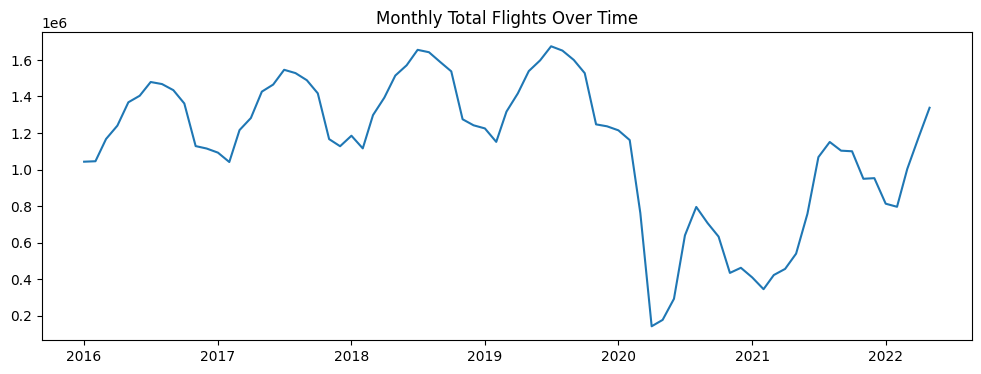

In [13]:
plt.figure(figsize=(12,4))
plt.plot(monthly_series.index, monthly_series.values)
plt.title("Monthly Total Flights Over Time")
plt.show()


Monthly Trend

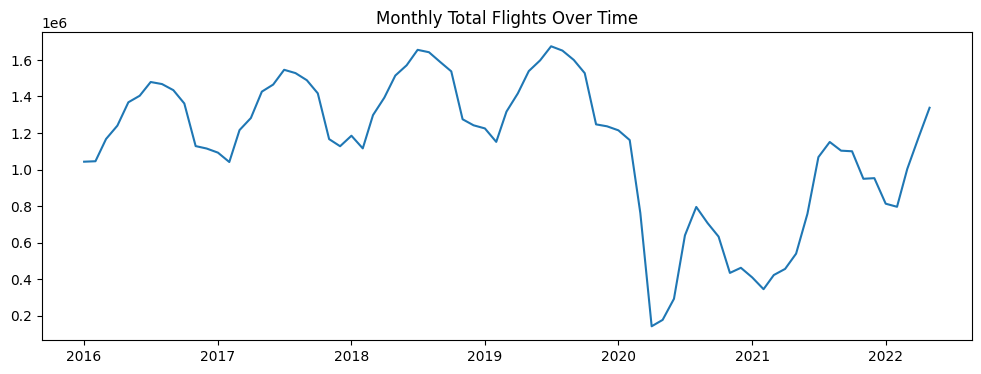

In [14]:
plt.figure(figsize=(12,4))
plt.plot(monthly_series.index, monthly_series.values)
plt.title("Monthly Total Flights Over Time")
plt.show()


Top 10 Airports by Total Flights

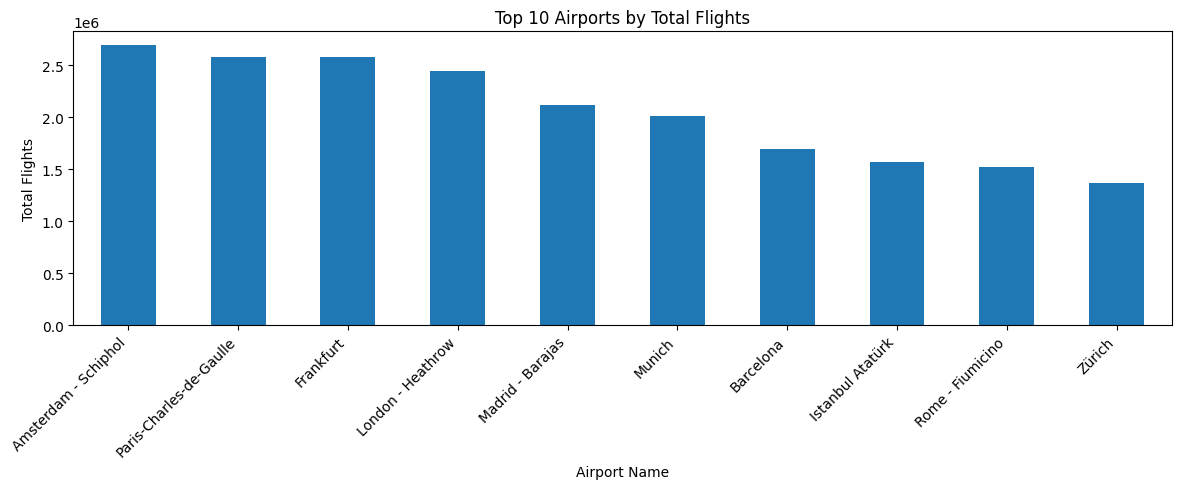

In [20]:
plt.figure(figsize=(12,5))
airport_s.head(10).plot(kind='bar')
plt.title("Top 10 Airports by Total Flights")
plt.xlabel("Airport Name")
plt.ylabel("Total Flights")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Top 25 Countries by Total Flights

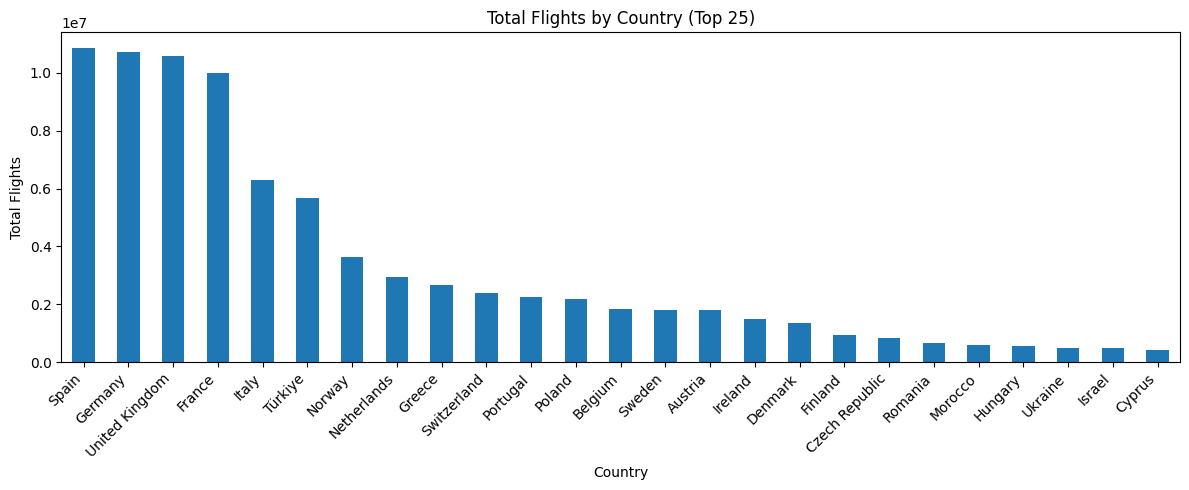

In [21]:
plt.figure(figsize=(12,5))
country_s.head(25).plot(kind='bar')
plt.title("Total Flights by Country (Top 25)")
plt.xlabel("Country")
plt.ylabel("Total Flights")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Average Flights by Calendar Month (Seasonality)

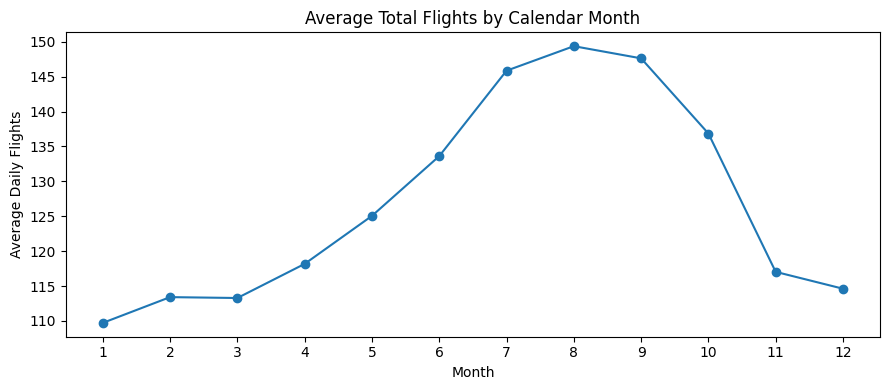

In [22]:
from collections import defaultdict

month_sum = defaultdict(float)
month_count = defaultdict(int)

for chunk in pd.read_csv(
    cleaned_csv,
    parse_dates=['FLT_DATE'],
    chunksize=100000,
    low_memory=True
):
    grp = chunk.groupby(chunk['FLT_DATE'].dt.month)['FLT_TOT_1'].agg(['sum','count'])
    for m,row in grp.iterrows():
        month_sum[m] += row['sum']
        month_count[m] += row['count']

months = sorted(month_sum.keys())
monthly_avg = [month_sum[m] / month_count[m] for m in months]

plt.figure(figsize=(9,4))
plt.plot(months, monthly_avg, marker='o')
plt.title("Average Total Flights by Calendar Month")
plt.xlabel("Month")
plt.ylabel("Average Daily Flights")
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


Average Flights by Weekday

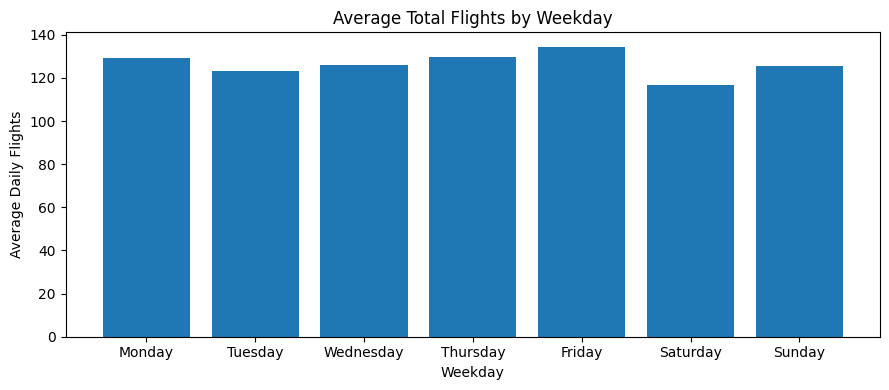

In [23]:
wd_sum = defaultdict(float)
wd_count = defaultdict(int)

for chunk in pd.read_csv(
    cleaned_csv,
    parse_dates=['FLT_DATE'],
    chunksize=100000,
    low_memory=True
):
    chunk['weekday'] = chunk['FLT_DATE'].dt.day_name()
    grp = chunk.groupby('weekday')['FLT_TOT_1'].agg(['sum','count'])
    for wd,row in grp.iterrows():
        wd_sum[wd] += row['sum']
        wd_count[wd] += row['count']

wd_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
wd_avg = [wd_sum[w] / wd_count[w] for w in wd_order]

plt.figure(figsize=(9,4))
plt.bar(wd_order, wd_avg)
plt.title("Average Total Flights by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average Daily Flights")
plt.tight_layout()
plt.show()


Distribution of Daily Flights (Histogram)

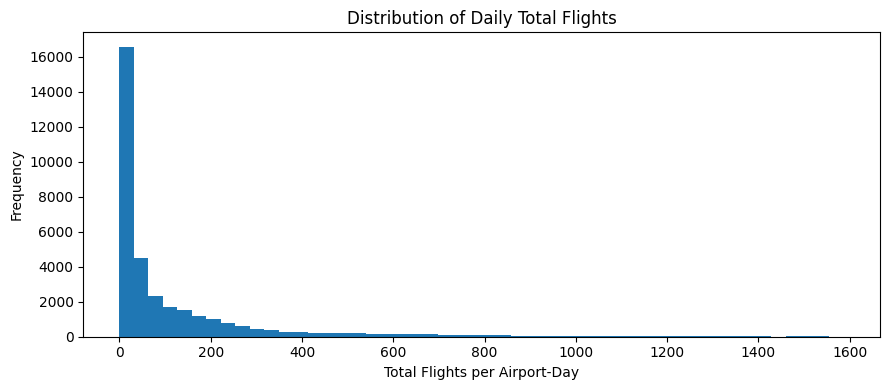

In [24]:
plt.figure(figsize=(9,4))
plt.hist(sample_df['FLT_TOT_1'].dropna(), bins=50)
plt.title("Distribution of Daily Total Flights")
plt.xlabel("Total Flights per Airport-Day")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Departures vs Total Flights (Scatter)

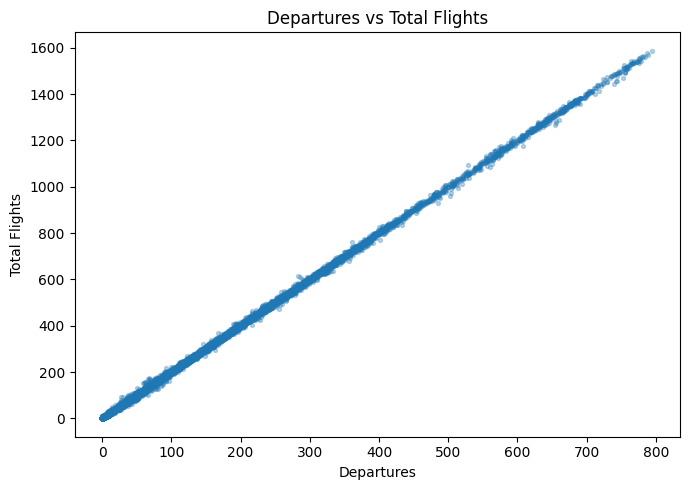

In [25]:
plt.figure(figsize=(7,5))
plt.scatter(
    sample_df['FLT_DEP_1'],
    sample_df['FLT_TOT_1'],
    alpha=0.3,
    s=8
)
plt.title("Departures vs Total Flights")
plt.xlabel("Departures")
plt.ylabel("Total Flights")
plt.tight_layout()
plt.show()


Month × Weekday Heatmap

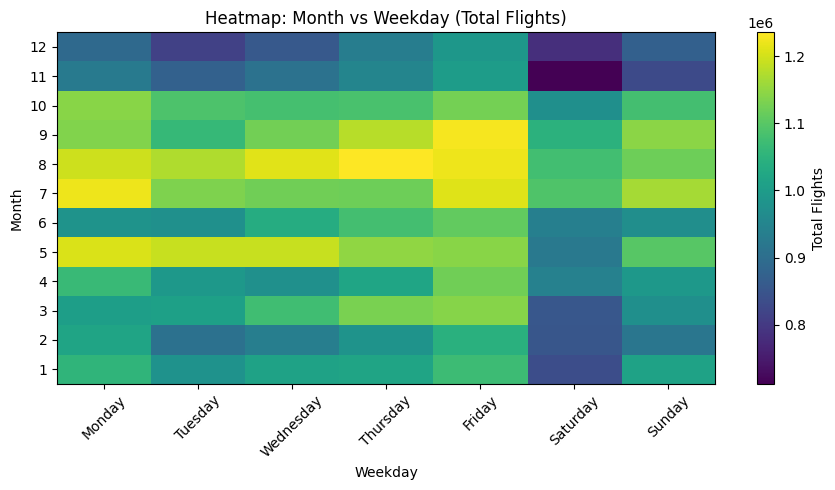

In [26]:
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heat_matrix = np.zeros((12,7))

for (m,wd), val in month_week_counts.items():
    if wd in weekdays:
        heat_matrix[m-1, weekdays.index(wd)] = val

plt.figure(figsize=(9,5))
plt.imshow(heat_matrix, aspect='auto', origin='lower')
plt.colorbar(label='Total Flights')
plt.yticks(range(12), range(1,13))
plt.xticks(range(7), weekdays, rotation=45)
plt.title("Heatmap: Month vs Weekday (Total Flights)")
plt.xlabel("Weekday")
plt.ylabel("Month")
plt.tight_layout()
plt.show()


IFR Share

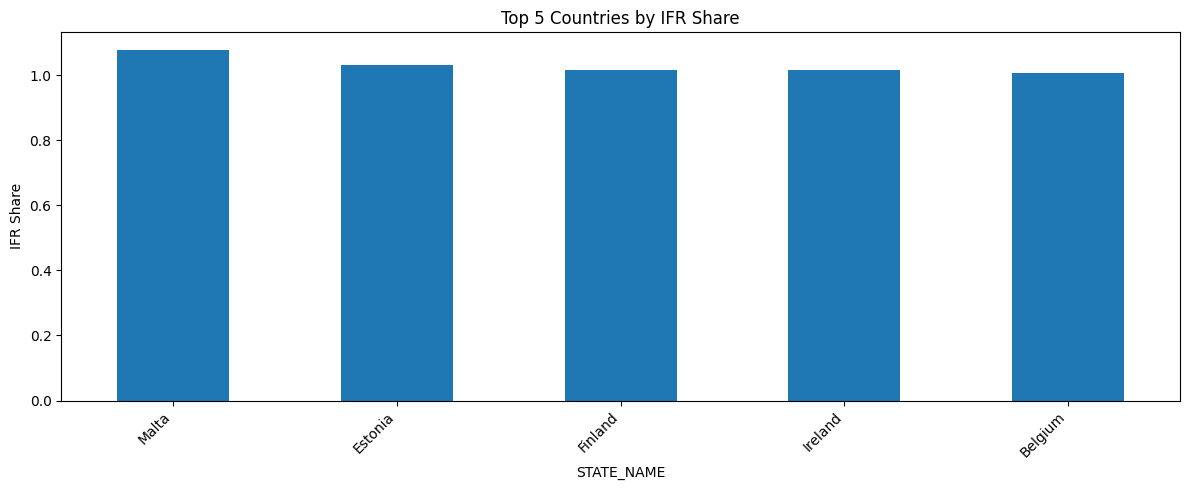

In [27]:
if 'FLT_TOT_IFR_2' in pd.read_csv(cleaned_csv, nrows=1).columns:
    df_ifr = pd.read_csv(
        cleaned_csv,
        usecols=['STATE_NAME','FLT_TOT_1','FLT_TOT_IFR_2']
    ).dropna()

    country_ifr = df_ifr.groupby('STATE_NAME')[['FLT_TOT_1','FLT_TOT_IFR_2']].sum()
    country_ifr['IFR_share'] = country_ifr['FLT_TOT_IFR_2'] / country_ifr['FLT_TOT_1']
    country_ifr = country_ifr.sort_values('IFR_share', ascending=False)

    plt.figure(figsize=(12,5))
    country_ifr['IFR_share'].head(5).plot(kind='bar')
    plt.title("Top 5 Countries by IFR Share")
    plt.ylabel("IFR Share")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# 5. Feature Engineering & Model Prep

In [15]:
# ---------- 5. FEATURE ENGINEERING ----------
df_model = pd.read_csv(cleaned_csv, parse_dates=['FLT_DATE'])
df_model = df_model.dropna(subset=['FLT_TOT_1']).copy()

df_model['median_by_airport'] = df_model.groupby('APT_ICAO')['FLT_TOT_1'].transform('median')
df_model['high_traffic'] = (df_model['FLT_TOT_1'] > df_model['median_by_airport']).astype(int)

df_model['month'] = df_model['FLT_DATE'].dt.month
df_model['weekday_num'] = df_model['FLT_DATE'].dt.dayofweek

df_model.drop(columns=['FLT_DEP_1','FLT_ARR_1'], errors='ignore', inplace=True)

le = LabelEncoder()
df_model['APT_code'] = le.fit_transform(df_model['APT_ICAO'].astype(str))
df_model['APTNAME_code'] = le.fit_transform(df_model['APT_NAME'].astype(str))
df_model['STATE_code'] = le.fit_transform(df_model['STATE_NAME'].astype(str))

features = ['APT_code','APTNAME_code','STATE_code','month','weekday_num']
X = df_model[features]
y_reg = df_model['FLT_TOT_1']
y_clf = df_model['high_traffic']


# 6. Regression Models

In [17]:
# ---------- 6. REGRESSION ----------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R2: {r2_rf:.3f}")



Random Forest RMSE: 96.05
Random Forest R2: 0.813


# 7. Classification Models

In [18]:
# ---------- 7. CLASSIFICATION ----------
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfc.fit(X_train_c, y_train_c)

pred = rfc.predict(X_test_c)
print("Accuracy:", accuracy_score(y_test_c, pred))
print(classification_report(y_test_c, pred))


Accuracy: 0.7014605435256503
              precision    recall  f1-score   support

           0       0.74      0.67      0.70     73252
           1       0.66      0.74      0.70     64368

    accuracy                           0.70    137620
   macro avg       0.70      0.70      0.70    137620
weighted avg       0.71      0.70      0.70    137620



# 8. Save Outputs

In [19]:
# ---------- 8. SAVE OUTPUTS ----------
out_file = "model_predictions_sample.csv"

X_test_out = X_test.copy()
X_test_out['actual_FLT_TOT_1'] = y_test.values
X_test_out['pred_RF'] = pred_rf

X_test_out.to_csv(out_file, index=False)
files.download(out_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>